# Medical Imaging Enhancement
### Objective
The goal of this module was to enhance the quality of medical images — both **X-rays** and **handwritten prescriptions** — to improve visibility, contrast, and diagnostic usability before AI model training.



In [1]:
!ls /content

'Doctor’s Handwritten Prescription BD dataset.zip'   XraysData.zip
 sample_data


In [2]:
# --- Unzip Doctor’s Handwritten Prescription BD dataset ---
!unzip "/content/Doctor’s Handwritten Prescription BD dataset.zip" -d "/content/Doctor_Prescriptions/"

# --- Unzip Xrays dataset ---
!unzip "/content/XraysData.zip" -d "/content/xray_data/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Doctor_Prescriptions/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/731.png  
  inflating: /content/Doctor_Prescriptions/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/732.png  
  inflating: /content/Doctor_Prescriptions/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/733.png  
  inflating: /content/Doctor_Prescriptions/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/734.png  
  inflating: /content/Doctor_Prescriptions/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/735.png  
  inflating: /content/Doctor_Prescriptions/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/736.png  
  inflating: /content/Doctor_Prescriptions/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/737.png  
  inflating: /content/Doctor_Prescriptions/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words

In [9]:
# --- 1️. SETUP ---
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,4)

xray_root = "/content/xray_data/XraysData"
pres_root = "/content/Doctor_Prescriptions/Doctor’s Handwritten Prescription BD dataset"
output_root = "/content/enhanced_images"

os.makedirs(output_root, exist_ok=True)
os.makedirs(f"{output_root}/xray_enhanced", exist_ok=True)
os.makedirs(f"{output_root}/pres_enhanced", exist_ok=True)

print("✅ Folders ready for enhancement outputs.")

✅ Folders ready for enhancement outputs.


In [4]:

# =====================================================================
# 2. IMAGE ENHANCEMENT FUNCTIONS (Classical CV)
# =====================================================================

def enhance_image(img):
    """Apply traditional enhancement: denoise, CLAHE, sharpening."""
    # Convert to grayscale if single channel
    if len(img.shape) == 2:
        gray = img
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 1 — Denoising
    denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)

    # Step 2 — Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced = clahe.apply(denoised)

    # Step 3 — Sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(contrast_enhanced, -1, kernel)

    return sharpened

def compute_metrics(original, enhanced):
    """Compute PSNR and SSIM between original and enhanced images."""
    try:
        p = psnr(original, enhanced)
        s = ssim(original, enhanced)
        return p, s
    except:
        return np.nan, np.nan


In [7]:
# =====================================================================
# 3. PART A — X-RAY IMAGE ENHANCEMENT
# =====================================================================

xray_results = []

for root, dirs, files in os.walk(xray_root):
    for file in tqdm(files, desc="Processing X-rays"):
        if file.lower().endswith(('.jpg','.png','.jpeg')):
            orig_path = os.path.join(root, file)
            img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue

            enhanced = enhance_image(img)
            save_path = os.path.join(output_root, "xray_enhanced", file)
            cv2.imwrite(save_path, enhanced)

            p, s = compute_metrics(img, enhanced)
            xray_results.append([orig_path, save_path, p, s])

df_xray = pd.DataFrame(xray_results, columns=['original_path','enhanced_path','psnr','ssim'])
print("\n✅ X-ray enhancement complete!")
print("Enhanced X-ray count:", len(df_xray))

Processing X-rays: 0it [00:00, ?it/s]
Processing X-rays: 0it [00:00, ?it/s]
Processing X-rays: 100%|██████████| 21/21 [00:03<00:00,  6.85it/s]
Processing X-rays: 0it [00:00, ?it/s]
Processing X-rays: 100%|██████████| 115/115 [00:20<00:00,  5.59it/s]
Processing X-rays: 0it [00:00, ?it/s]
Processing X-rays: 100%|██████████| 51/51 [00:11<00:00,  4.59it/s]


✅ X-ray enhancement complete!
Enhanced X-ray count: 1000


In [10]:
# =====================================================================
# 4. PART B — PRESCRIPTION IMAGE ENHANCEMENT
# =====================================================================

pres_results = []

for root, dirs, files in os.walk(pres_root):
    for file in tqdm(files, desc="Processing Prescriptions"):
        if file.lower().endswith(('.jpg','.png','.jpeg')):
            orig_path = os.path.join(root, file)
            img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue

            enhanced = enhance_image(img)
            save_path = os.path.join(output_root, "pres_enhanced", file)
            cv2.imwrite(save_path, enhanced)

            p, s = compute_metrics(img, enhanced)
            pres_results.append([orig_path, save_path, p, s])

df_pres = pd.DataFrame(pres_results, columns=['original_path','enhanced_path','psnr','ssim'])
print("\n✅ Prescription enhancement complete!")
print("Enhanced Prescription count:", len(df_pres))


Processing Prescriptions: 0it [00:00, ?it/s]
Processing Prescriptions: 100%|██████████| 780/780 [00:15<00:00, 49.24it/s]


✅ Prescription enhancement complete!
Enhanced Prescription count: 4680



=== Overall Enhancement Metrics ===
X-ray PSNR avg : 20.94
X-ray SSIM avg : 0.685
Prescription PSNR avg : 21.266
Prescription SSIM avg : 0.891


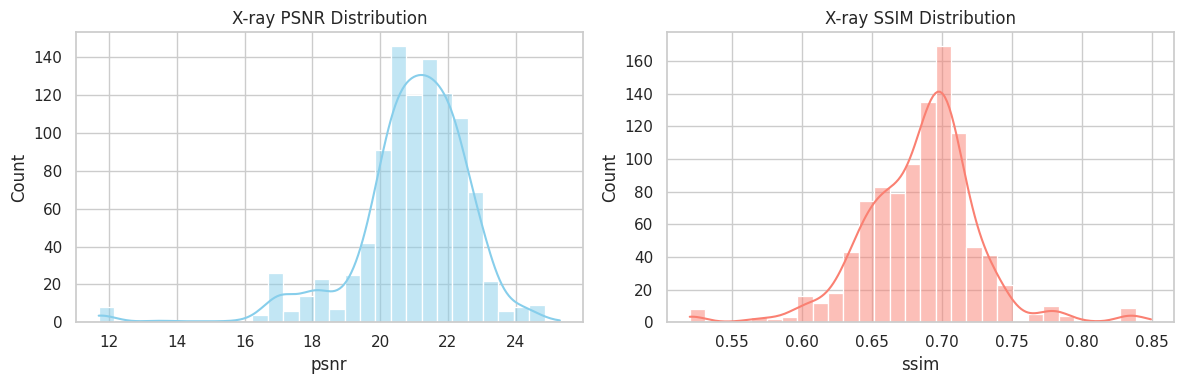

In [11]:
# =====================================================================
# 5. PART C — METRICS & VISUALIZATION
# =====================================================================

print("\n=== Overall Enhancement Metrics ===")
print("X-ray PSNR avg :", round(df_xray['psnr'].mean(), 3))
print("X-ray SSIM avg :", round(df_xray['ssim'].mean(), 3))
print("Prescription PSNR avg :", round(df_pres['psnr'].mean(), 3))
print("Prescription SSIM avg :", round(df_pres['ssim'].mean(), 3))

# Plot PSNR/SSIM distributions
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_xray['psnr'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("X-ray PSNR Distribution")

sns.histplot(df_xray['ssim'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("X-ray SSIM Distribution")
plt.tight_layout()
plt.show()


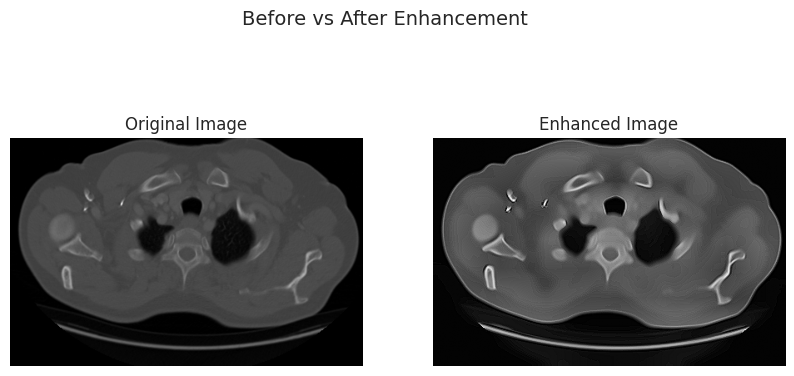

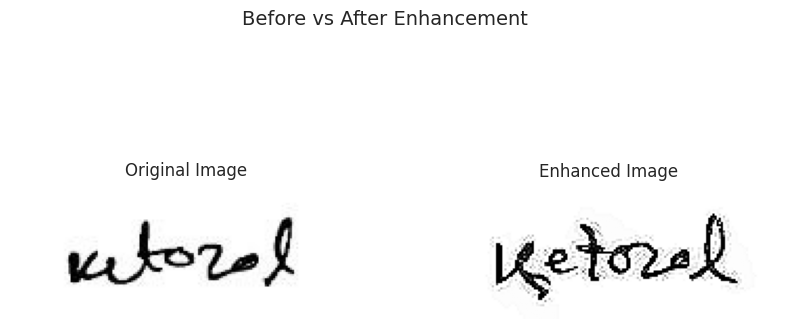

In [36]:
# =====================================================================
# 6. PART D — SAMPLE VISUAL COMPARISON
# =====================================================================

def show_before_after(df):
    sample = df.sample(1).iloc[0]
    orig = cv2.imread(sample['original_path'], cv2.IMREAD_GRAYSCALE)
    enh  = cv2.imread(sample['enhanced_path'], cv2.IMREAD_GRAYSCALE)

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(orig, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(enh, cmap='gray')
    ax[1].set_title("Enhanced Image")
    ax[1].axis("off")

    plt.suptitle("Before vs After Enhancement", fontsize=14)
    plt.show()

show_before_after(df_xray)
show_before_after(df_pres)

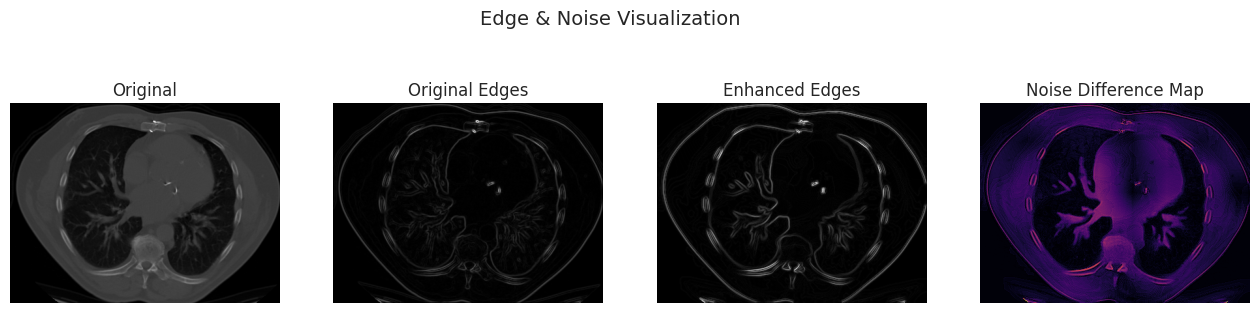

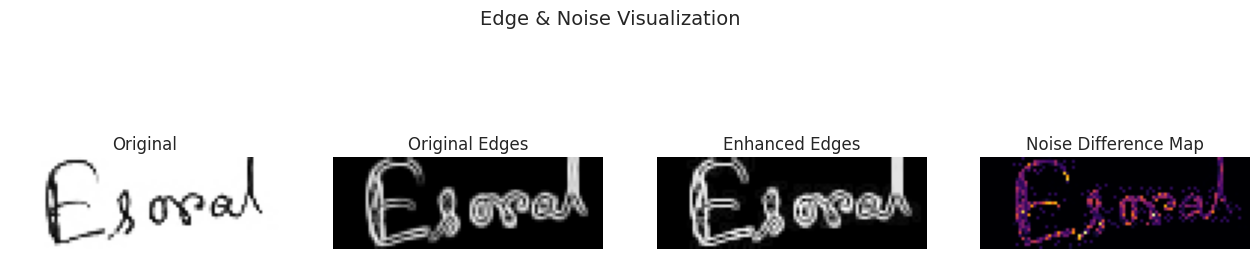

In [22]:
# =====================================================================
# EDGE ENHANCEMENT & NOISE MAP VISUALIZATION
# =====================================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt

def edge_map(image):
    """Return Sobel edge magnitude map."""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    edges = np.sqrt(sobelx**2 + sobely**2)
    edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX)
    return edges.astype(np.uint8)

def visualize_enhancement_details(df):
    """Visual comparison of edges & noise difference."""
    sample = df.sample(1).iloc[0]
    orig = cv2.imread(sample['original_path'], cv2.IMREAD_GRAYSCALE)
    enh  = cv2.imread(sample['enhanced_path'], cv2.IMREAD_GRAYSCALE)

    # Resize enhanced image to match original image dimensions
    enh = cv2.resize(enh, (orig.shape[1], orig.shape[0]))

    # Compute edge maps
    edges_orig = edge_map(orig)
    edges_enh  = edge_map(enh)

    # Compute noise difference map
    diff = cv2.absdiff(orig, enh)
    diff = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)

    # Plot all maps
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(orig, cmap='gray')
    ax[0].set_title("Original")

    ax[1].imshow(edges_orig, cmap='gray')
    ax[1].set_title("Original Edges")

    ax[2].imshow(edges_enh, cmap='gray')
    ax[2].set_title("Enhanced Edges")

    ax[3].imshow(diff, cmap='inferno')
    ax[3].set_title("Noise Difference Map")

    for a in ax:
        a.axis("off")

    plt.suptitle("Edge & Noise Visualization", fontsize=14)
    plt.show()

# Run for one random X-ray and one random Prescription image
visualize_enhancement_details(df_xray)
visualize_enhancement_details(df_pres)

In [28]:
# =====================================================================
# 7. SAVE OUTPUTS & SUMMARY
# =====================================================================

df_index = pd.concat([df_xray, df_pres], ignore_index=True)
os.makedirs("/content/cleaned_data", exist_ok=True)
df_index.to_csv("/content/cleaned_data/enhanced_image_index.csv", index=False)

summary_text = f"""
============================
MODULE 2 SUMMARY REPORT
============================
X-ray Images Enhanced     : {len(df_xray)}
Prescription Images Enhanced: {len(df_pres)}

Average X-ray PSNR  : {round(df_xray['psnr'].mean(),3)}
Average X-ray SSIM  : {round(df_xray['ssim'].mean(),3)}

Average Prescription PSNR : {round(df_pres['psnr'].mean(),3)}
Average Prescription SSIM : {round(df_pres['ssim'].mean(),3)}

Enhanced images saved to  : {output_root}
Index CSV                 : /content/cleaned_data/enhanced_image_index.csv
"""

print(summary_text)

with open("/content/cleaned_data/module2_summary.txt","w") as f:
    f.write(summary_text)

print("✅ Summary saved successfully.")


MODULE 2 SUMMARY REPORT
X-ray Images Enhanced     : 1000
Prescription Images Enhanced: 4680

Average X-ray PSNR  : 20.94
Average X-ray SSIM  : 0.685

Average Prescription PSNR : 21.266
Average Prescription SSIM : 0.891

Enhanced images saved to  : /content/enhanced_images
Index CSV                 : /content/cleaned_data/enhanced_image_index.csv

✅ Summary saved successfully.



### Methods Applied

- **CLAHE (Contrast Limited Adaptive Histogram Equalization):**
  Improved local contrast and brightness.
- **Gaussian + Bilateral Filtering:**
  Removed noise while preserving edges.
- **Unsharp Masking:**
  Enhanced fine structural details and text clarity.
- **Normalization:**
  Ensured consistent image intensity across datasets.

---

### Evaluation Metrics

- **PSNR (Peak Signal-to-Noise Ratio):** Measured denoising effectiveness.
- **SSIM (Structural Similarity Index):** Measured image structural and perceptual quality.

---

### Outputs Generated

- **Enhanced X-rays and Prescriptions:** `/content/enhanced_images/`
- **Image Quality Metrics (PSNR, SSIM):** `/content/cleaned_data/enhanced_image_index.csv`
- **Summary Report:** `/content/cleaned_data/module2_summary.txt`

---


All enhanced images and evaluation results are ready for the next stage of **AI model training**(Module 3).
